<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:12:37] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


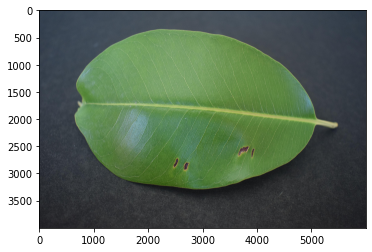

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

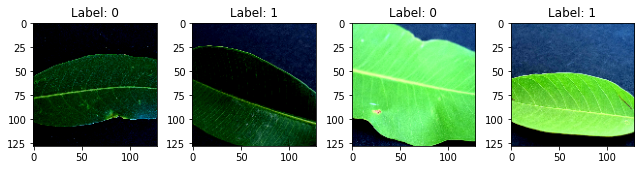

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:12:44] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:12:46] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2498160722325837 samples/sec                   batch loss = 1.5658276081085205 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2680998572886384 samples/sec                   batch loss = 1.3172974586486816 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2783995621936008 samples/sec                   batch loss = 2.1697499752044678 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2681453871380255 samples/sec                   batch loss = 0.9537399411201477 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2647105228184325 samples/sec                   batch loss = 0.9662284851074219 | accuracy = 0.48


Epoch[1] Batch[30] Speed: 1.263802706794466 samples/sec                   batch loss = 0.7255743145942688 | accuracy = 0.48333333333333334


Epoch[1] Batch[35] Speed: 1.2653500819672625 samples/sec                   batch loss = 0.368378609418869 | accuracy = 0.5071428571428571


Epoch[1] Batch[40] Speed: 1.2705293837091711 samples/sec                   batch loss = 0.23341114819049835 | accuracy = 0.50625


Epoch[1] Batch[45] Speed: 1.2706421594503978 samples/sec                   batch loss = 0.4346201717853546 | accuracy = 0.5222222222222223


Epoch[1] Batch[50] Speed: 1.2722072067255876 samples/sec                   batch loss = 1.0921162366867065 | accuracy = 0.525


Epoch[1] Batch[55] Speed: 1.2618701476595457 samples/sec                   batch loss = 1.0624330043792725 | accuracy = 0.5181818181818182


Epoch[1] Batch[60] Speed: 1.263715890015274 samples/sec                   batch loss = 0.6318545937538147 | accuracy = 0.5291666666666667


Epoch[1] Batch[65] Speed: 1.2665692751326438 samples/sec                   batch loss = 0.8964670300483704 | accuracy = 0.5346153846153846


Epoch[1] Batch[70] Speed: 1.2718116066229777 samples/sec                   batch loss = 0.8574200868606567 | accuracy = 0.5392857142857143


Epoch[1] Batch[75] Speed: 1.2718086178953003 samples/sec                   batch loss = 0.9710206985473633 | accuracy = 0.5366666666666666


Epoch[1] Batch[80] Speed: 1.270863342704034 samples/sec                   batch loss = 0.604299783706665 | accuracy = 0.540625


Epoch[1] Batch[85] Speed: 1.2653149633616203 samples/sec                   batch loss = 0.7282348871231079 | accuracy = 0.5441176470588235


Epoch[1] Batch[90] Speed: 1.2647465613048923 samples/sec                   batch loss = 0.6684960722923279 | accuracy = 0.55


Epoch[1] Batch[95] Speed: 1.2680346834046803 samples/sec                   batch loss = 0.6419511437416077 | accuracy = 0.5605263157894737


Epoch[1] Batch[100] Speed: 1.2677992506501383 samples/sec                   batch loss = 0.7858550548553467 | accuracy = 0.5575


Epoch[1] Batch[105] Speed: 1.2625921570533944 samples/sec                   batch loss = 0.9849761724472046 | accuracy = 0.569047619047619


Epoch[1] Batch[110] Speed: 1.2631011840414186 samples/sec                   batch loss = 0.534618079662323 | accuracy = 0.5727272727272728


Epoch[1] Batch[115] Speed: 1.2726670561663973 samples/sec                   batch loss = 0.5757663249969482 | accuracy = 0.5717391304347826


Epoch[1] Batch[120] Speed: 1.2783793981872347 samples/sec                   batch loss = 0.9006019234657288 | accuracy = 0.575


Epoch[1] Batch[125] Speed: 1.274144681492233 samples/sec                   batch loss = 0.566506564617157 | accuracy = 0.58


Epoch[1] Batch[130] Speed: 1.272685495676058 samples/sec                   batch loss = 0.6129484176635742 | accuracy = 0.5884615384615385


Epoch[1] Batch[135] Speed: 1.270326591711523 samples/sec                   batch loss = 0.6564406156539917 | accuracy = 0.5981481481481481


Epoch[1] Batch[140] Speed: 1.2738177969727458 samples/sec                   batch loss = 0.5406220555305481 | accuracy = 0.6


Epoch[1] Batch[145] Speed: 1.276183289721901 samples/sec                   batch loss = 0.22103600203990936 | accuracy = 0.6017241379310345


Epoch[1] Batch[150] Speed: 1.2734220646431937 samples/sec                   batch loss = 0.6148353815078735 | accuracy = 0.6033333333333334


Epoch[1] Batch[155] Speed: 1.2698623764536017 samples/sec                   batch loss = 0.25146862864494324 | accuracy = 0.6096774193548387


Epoch[1] Batch[160] Speed: 1.2664181216914243 samples/sec                   batch loss = 0.2721768021583557 | accuracy = 0.6140625


Epoch[1] Batch[165] Speed: 1.268838803203268 samples/sec                   batch loss = 0.4717181622982025 | accuracy = 0.6151515151515151


Epoch[1] Batch[170] Speed: 1.2712350423244518 samples/sec                   batch loss = 0.703127384185791 | accuracy = 0.6176470588235294


Epoch[1] Batch[175] Speed: 1.2776462308093754 samples/sec                   batch loss = 0.33257952332496643 | accuracy = 0.6185714285714285


Epoch[1] Batch[180] Speed: 1.2752063015069695 samples/sec                   batch loss = 0.23416824638843536 | accuracy = 0.625


Epoch[1] Batch[185] Speed: 1.2662362308866038 samples/sec                   batch loss = 0.8974639773368835 | accuracy = 0.6270270270270271


Epoch[1] Batch[190] Speed: 1.2766004591045697 samples/sec                   batch loss = 0.556163489818573 | accuracy = 0.631578947368421


Epoch[1] Batch[195] Speed: 1.2721153731688792 samples/sec                   batch loss = 1.02141273021698 | accuracy = 0.6333333333333333


Epoch[1] Batch[200] Speed: 1.2762966830863085 samples/sec                   batch loss = 0.3066830635070801 | accuracy = 0.63625


Epoch[1] Batch[205] Speed: 1.2773497370834364 samples/sec                   batch loss = 0.5449370741844177 | accuracy = 0.6341463414634146


Epoch[1] Batch[210] Speed: 1.2723208594611275 samples/sec                   batch loss = 0.5718950033187866 | accuracy = 0.6369047619047619


Epoch[1] Batch[215] Speed: 1.2752484657803866 samples/sec                   batch loss = 0.46292492747306824 | accuracy = 0.6337209302325582


Epoch[1] Batch[220] Speed: 1.2714312833848722 samples/sec                   batch loss = 0.7836142182350159 | accuracy = 0.6329545454545454


Epoch[1] Batch[225] Speed: 1.2745233380549674 samples/sec                   batch loss = 0.53033447265625 | accuracy = 0.6355555555555555


Epoch[1] Batch[230] Speed: 1.2732188313751627 samples/sec                   batch loss = 0.2746948301792145 | accuracy = 0.6369565217391304


Epoch[1] Batch[235] Speed: 1.270182714078337 samples/sec                   batch loss = 0.7925673127174377 | accuracy = 0.6361702127659574


Epoch[1] Batch[240] Speed: 1.2730417437283186 samples/sec                   batch loss = 0.45820701122283936 | accuracy = 0.6375


Epoch[1] Batch[245] Speed: 1.2797162738424845 samples/sec                   batch loss = 1.1619772911071777 | accuracy = 0.6387755102040816


Epoch[1] Batch[250] Speed: 1.2754817282011333 samples/sec                   batch loss = 0.686571478843689 | accuracy = 0.636


Epoch[1] Batch[255] Speed: 1.2757606692543508 samples/sec                   batch loss = 0.955394983291626 | accuracy = 0.634313725490196


Epoch[1] Batch[260] Speed: 1.2643827431800931 samples/sec                   batch loss = 0.8516615629196167 | accuracy = 0.6288461538461538


Epoch[1] Batch[265] Speed: 1.2701980043377117 samples/sec                   batch loss = 0.4982721209526062 | accuracy = 0.6330188679245283


Epoch[1] Batch[270] Speed: 1.2706739173243256 samples/sec                   batch loss = 0.2951337993144989 | accuracy = 0.6342592592592593


Epoch[1] Batch[275] Speed: 1.2798731571021214 samples/sec                   batch loss = 0.8691143989562988 | accuracy = 0.6345454545454545


Epoch[1] Batch[280] Speed: 1.2675473376786648 samples/sec                   batch loss = 0.4850350320339203 | accuracy = 0.6339285714285714


Epoch[1] Batch[285] Speed: 1.2698715074914793 samples/sec                   batch loss = 0.40484189987182617 | accuracy = 0.6359649122807017


Epoch[1] Batch[290] Speed: 1.271927502961058 samples/sec                   batch loss = 0.5160481333732605 | accuracy = 0.6370689655172413


Epoch[1] Batch[295] Speed: 1.2732166090209085 samples/sec                   batch loss = 0.6110519766807556 | accuracy = 0.6372881355932203


Epoch[1] Batch[300] Speed: 1.2697168742647589 samples/sec                   batch loss = 1.5820262432098389 | accuracy = 0.6333333333333333


Epoch[1] Batch[305] Speed: 1.2737800791620932 samples/sec                   batch loss = 0.5201997756958008 | accuracy = 0.6344262295081967


Epoch[1] Batch[310] Speed: 1.2726651253585939 samples/sec                   batch loss = 0.6007601022720337 | accuracy = 0.6362903225806451


Epoch[1] Batch[315] Speed: 1.266609053318368 samples/sec                   batch loss = 0.5383024215698242 | accuracy = 0.6349206349206349


Epoch[1] Batch[320] Speed: 1.2722436737271225 samples/sec                   batch loss = 0.5144469738006592 | accuracy = 0.63671875


Epoch[1] Batch[325] Speed: 1.2766119215162761 samples/sec                   batch loss = 0.5626134872436523 | accuracy = 0.6384615384615384


Epoch[1] Batch[330] Speed: 1.2693413559738285 samples/sec                   batch loss = 0.9262676239013672 | accuracy = 0.6409090909090909


Epoch[1] Batch[335] Speed: 1.27183956636871 samples/sec                   batch loss = 0.5142776966094971 | accuracy = 0.6425373134328358


Epoch[1] Batch[340] Speed: 1.266294147353923 samples/sec                   batch loss = 0.5459279417991638 | accuracy = 0.6448529411764706


Epoch[1] Batch[345] Speed: 1.2691256943243043 samples/sec                   batch loss = 0.5022860169410706 | accuracy = 0.6434782608695652


Epoch[1] Batch[350] Speed: 1.2761287360532418 samples/sec                   batch loss = 0.512174129486084 | accuracy = 0.6435714285714286


Epoch[1] Batch[355] Speed: 1.2744739605616273 samples/sec                   batch loss = 0.30547595024108887 | accuracy = 0.6464788732394366


Epoch[1] Batch[360] Speed: 1.2774252093044576 samples/sec                   batch loss = 0.6761146783828735 | accuracy = 0.6472222222222223


Epoch[1] Batch[365] Speed: 1.268011969963536 samples/sec                   batch loss = 0.5132761001586914 | accuracy = 0.65


Epoch[1] Batch[370] Speed: 1.2625303983184337 samples/sec                   batch loss = 0.22951650619506836 | accuracy = 0.6506756756756756


Epoch[1] Batch[375] Speed: 1.2641123742779312 samples/sec                   batch loss = 0.8774819374084473 | accuracy = 0.648


Epoch[1] Batch[380] Speed: 1.267066299332686 samples/sec                   batch loss = 0.566839873790741 | accuracy = 0.6486842105263158


Epoch[1] Batch[385] Speed: 1.2664144890988758 samples/sec                   batch loss = 0.7136051654815674 | accuracy = 0.6454545454545455


Epoch[1] Batch[390] Speed: 1.2596305651799558 samples/sec                   batch loss = 0.3410258889198303 | accuracy = 0.6442307692307693


Epoch[1] Batch[395] Speed: 1.2639873272907527 samples/sec                   batch loss = 0.7373815178871155 | accuracy = 0.6443037974683544


Epoch[1] Batch[400] Speed: 1.263361607057806 samples/sec                   batch loss = 1.232483148574829 | accuracy = 0.645


Epoch[1] Batch[405] Speed: 1.2687694274745052 samples/sec                   batch loss = 0.4775097370147705 | accuracy = 0.6475308641975308


Epoch[1] Batch[410] Speed: 1.2644020868960206 samples/sec                   batch loss = 0.5491930842399597 | accuracy = 0.6475609756097561


Epoch[1] Batch[415] Speed: 1.2673931741894173 samples/sec                   batch loss = 0.6780092120170593 | accuracy = 0.65


Epoch[1] Batch[420] Speed: 1.2635019451970901 samples/sec                   batch loss = 0.6007294654846191 | accuracy = 0.6488095238095238


Epoch[1] Batch[425] Speed: 1.2707457152175616 samples/sec                   batch loss = 0.24151410162448883 | accuracy = 0.65


Epoch[1] Batch[430] Speed: 1.2748992164755861 samples/sec                   batch loss = 0.8180509209632874 | accuracy = 0.6505813953488372


Epoch[1] Batch[435] Speed: 1.2702133911338476 samples/sec                   batch loss = 0.4303906261920929 | accuracy = 0.6511494252873563


Epoch[1] Batch[440] Speed: 1.2662150152888003 samples/sec                   batch loss = 0.587944507598877 | accuracy = 0.6505681818181818


Epoch[1] Batch[445] Speed: 1.2615071285852242 samples/sec                   batch loss = 0.18081890046596527 | accuracy = 0.6511235955056179


Epoch[1] Batch[450] Speed: 1.265675307956029 samples/sec                   batch loss = 0.2611533999443054 | accuracy = 0.6516666666666666


Epoch[1] Batch[455] Speed: 1.271728602344523 samples/sec                   batch loss = 0.6134434342384338 | accuracy = 0.6521978021978022


Epoch[1] Batch[460] Speed: 1.2710308695081673 samples/sec                   batch loss = 0.25610873103141785 | accuracy = 0.6543478260869565


Epoch[1] Batch[465] Speed: 1.271432054210491 samples/sec                   batch loss = 0.9186128973960876 | accuracy = 0.6553763440860215


Epoch[1] Batch[470] Speed: 1.266645869490573 samples/sec                   batch loss = 0.30695998668670654 | accuracy = 0.6558510638297872


Epoch[1] Batch[475] Speed: 1.2689407215586448 samples/sec                   batch loss = 0.8556746244430542 | accuracy = 0.6568421052631579


Epoch[1] Batch[480] Speed: 1.2692478231776028 samples/sec                   batch loss = 0.3616149127483368 | accuracy = 0.6588541666666666


Epoch[1] Batch[485] Speed: 1.2758216917465277 samples/sec                   batch loss = 0.5158547163009644 | accuracy = 0.6587628865979381


Epoch[1] Batch[490] Speed: 1.271771983020012 samples/sec                   batch loss = 0.43451130390167236 | accuracy = 0.6602040816326531


Epoch[1] Batch[495] Speed: 1.2625075016150813 samples/sec                   batch loss = 0.350188672542572 | accuracy = 0.6606060606060606


Epoch[1] Batch[500] Speed: 1.265029410782267 samples/sec                   batch loss = 0.6731278896331787 | accuracy = 0.6625


Epoch[1] Batch[505] Speed: 1.2689316039014853 samples/sec                   batch loss = 0.8567162752151489 | accuracy = 0.6648514851485149


Epoch[1] Batch[510] Speed: 1.2742769727664305 samples/sec                   batch loss = 0.6716761589050293 | accuracy = 0.6651960784313725


Epoch[1] Batch[515] Speed: 1.2770555194965587 samples/sec                   batch loss = 0.2943280339241028 | accuracy = 0.666504854368932


Epoch[1] Batch[520] Speed: 1.264377311799781 samples/sec                   batch loss = 0.7292236685752869 | accuracy = 0.6677884615384615


Epoch[1] Batch[525] Speed: 1.2686494052313628 samples/sec                   batch loss = 0.7508172392845154 | accuracy = 0.6695238095238095


Epoch[1] Batch[530] Speed: 1.2694162689750774 samples/sec                   batch loss = 0.3222697973251343 | accuracy = 0.6707547169811321


Epoch[1] Batch[535] Speed: 1.2743429835132052 samples/sec                   batch loss = 0.7379615902900696 | accuracy = 0.6696261682242991


Epoch[1] Batch[540] Speed: 1.2687554189119032 samples/sec                   batch loss = 0.6000292301177979 | accuracy = 0.6708333333333333


Epoch[1] Batch[545] Speed: 1.2614853123479979 samples/sec                   batch loss = 0.18466465175151825 | accuracy = 0.6720183486238532


Epoch[1] Batch[550] Speed: 1.2715217654257849 samples/sec                   batch loss = 0.4768470227718353 | accuracy = 0.6722727272727272


Epoch[1] Batch[555] Speed: 1.27561584909287 samples/sec                   batch loss = 0.517519474029541 | accuracy = 0.672972972972973


Epoch[1] Batch[560] Speed: 1.272112479469755 samples/sec                   batch loss = 0.28713011741638184 | accuracy = 0.6732142857142858


Epoch[1] Batch[565] Speed: 1.2733192319047477 samples/sec                   batch loss = 0.7701175808906555 | accuracy = 0.6743362831858407


Epoch[1] Batch[570] Speed: 1.2662542933747458 samples/sec                   batch loss = 0.35743293166160583 | accuracy = 0.675


Epoch[1] Batch[575] Speed: 1.2678536693375613 samples/sec                   batch loss = 0.633090615272522 | accuracy = 0.6756521739130434


Epoch[1] Batch[580] Speed: 1.2748705407936223 samples/sec                   batch loss = 0.5443626642227173 | accuracy = 0.6754310344827587


Epoch[1] Batch[585] Speed: 1.2731053079847725 samples/sec                   batch loss = 0.3673466444015503 | accuracy = 0.6752136752136753


Epoch[1] Batch[590] Speed: 1.2770269411385466 samples/sec                   batch loss = 0.7504091262817383 | accuracy = 0.675


Epoch[1] Batch[595] Speed: 1.269959556657581 samples/sec                   batch loss = 0.20921805500984192 | accuracy = 0.6764705882352942


Epoch[1] Batch[600] Speed: 1.265422138470261 samples/sec                   batch loss = 0.64682936668396 | accuracy = 0.6770833333333334


Epoch[1] Batch[605] Speed: 1.2625789496775788 samples/sec                   batch loss = 0.566361665725708 | accuracy = 0.6776859504132231


Epoch[1] Batch[610] Speed: 1.2728900073161593 samples/sec                   batch loss = 0.6007903814315796 | accuracy = 0.6770491803278689


Epoch[1] Batch[615] Speed: 1.265581455415777 samples/sec                   batch loss = 0.5921876430511475 | accuracy = 0.6760162601626016


Epoch[1] Batch[620] Speed: 1.2704156659915233 samples/sec                   batch loss = 0.40162521600723267 | accuracy = 0.6778225806451613


Epoch[1] Batch[625] Speed: 1.2675321111681688 samples/sec                   batch loss = 0.287720650434494 | accuracy = 0.678


Epoch[1] Batch[630] Speed: 1.2745269204925596 samples/sec                   batch loss = 0.7538226842880249 | accuracy = 0.6785714285714286


Epoch[1] Batch[635] Speed: 1.2690979497716908 samples/sec                   batch loss = 0.49831119179725647 | accuracy = 0.6775590551181102


Epoch[1] Batch[640] Speed: 1.2755981004576264 samples/sec                   batch loss = 0.38391661643981934 | accuracy = 0.678515625


Epoch[1] Batch[645] Speed: 1.2728532135469228 samples/sec                   batch loss = 0.581179141998291 | accuracy = 0.6786821705426357


Epoch[1] Batch[650] Speed: 1.2653823393606602 samples/sec                   batch loss = 0.2104739099740982 | accuracy = 0.6792307692307692


Epoch[1] Batch[655] Speed: 1.265909379349456 samples/sec                   batch loss = 1.6097867488861084 | accuracy = 0.6801526717557251


Epoch[1] Batch[660] Speed: 1.2702423385544062 samples/sec                   batch loss = 0.2993033528327942 | accuracy = 0.6806818181818182


Epoch[1] Batch[665] Speed: 1.2709916796836145 samples/sec                   batch loss = 0.2770252227783203 | accuracy = 0.6815789473684211


Epoch[1] Batch[670] Speed: 1.2736910159667492 samples/sec                   batch loss = 1.0680480003356934 | accuracy = 0.6817164179104478


Epoch[1] Batch[675] Speed: 1.2661191716968918 samples/sec                   batch loss = 0.42201852798461914 | accuracy = 0.6833333333333333


Epoch[1] Batch[680] Speed: 1.2650960886058062 samples/sec                   batch loss = 0.6375284194946289 | accuracy = 0.6834558823529412


Epoch[1] Batch[685] Speed: 1.2690321933067337 samples/sec                   batch loss = 0.7986834049224854 | accuracy = 0.6828467153284672


Epoch[1] Batch[690] Speed: 1.2752784186477555 samples/sec                   batch loss = 0.5965079069137573 | accuracy = 0.6840579710144927


Epoch[1] Batch[695] Speed: 1.270044926021233 samples/sec                   batch loss = 1.0317989587783813 | accuracy = 0.6845323741007194


Epoch[1] Batch[700] Speed: 1.2663568483797794 samples/sec                   batch loss = 1.0032294988632202 | accuracy = 0.6857142857142857


Epoch[1] Batch[705] Speed: 1.27137713522415 samples/sec                   batch loss = 0.6657389998435974 | accuracy = 0.6854609929078014


Epoch[1] Batch[710] Speed: 1.2707730505962187 samples/sec                   batch loss = 0.33374446630477905 | accuracy = 0.6859154929577465


Epoch[1] Batch[715] Speed: 1.2700480987525573 samples/sec                   batch loss = 0.3003115653991699 | accuracy = 0.6863636363636364


Epoch[1] Batch[720] Speed: 1.2726466864392014 samples/sec                   batch loss = 0.7874515652656555 | accuracy = 0.6868055555555556


Epoch[1] Batch[725] Speed: 1.2646323511509499 samples/sec                   batch loss = 0.3373096287250519 | accuracy = 0.6875862068965517


Epoch[1] Batch[730] Speed: 1.2695986902953116 samples/sec                   batch loss = 0.3655592203140259 | accuracy = 0.6876712328767123


Epoch[1] Batch[735] Speed: 1.2779703134144327 samples/sec                   batch loss = 0.3277570307254791 | accuracy = 0.6863945578231293


Epoch[1] Batch[740] Speed: 1.2698000005600762 samples/sec                   batch loss = 0.7663917541503906 | accuracy = 0.6864864864864865


Epoch[1] Batch[745] Speed: 1.268036600188 samples/sec                   batch loss = 0.6858302354812622 | accuracy = 0.6869127516778524


Epoch[1] Batch[750] Speed: 1.263382346595753 samples/sec                   batch loss = 0.42649513483047485 | accuracy = 0.6873333333333334


Epoch[1] Batch[755] Speed: 1.2672531190136809 samples/sec                   batch loss = 0.5634027123451233 | accuracy = 0.6880794701986755


Epoch[1] Batch[760] Speed: 1.2715350641913445 samples/sec                   batch loss = 0.6514068245887756 | accuracy = 0.687171052631579


Epoch[1] Batch[765] Speed: 1.2731077231652768 samples/sec                   batch loss = 0.44310957193374634 | accuracy = 0.6866013071895425


Epoch[1] Batch[770] Speed: 1.2780966820421766 samples/sec                   batch loss = 0.5720623135566711 | accuracy = 0.6863636363636364


Epoch[1] Batch[775] Speed: 1.268777391384313 samples/sec                   batch loss = 0.20744071900844574 | accuracy = 0.6870967741935484


Epoch[1] Batch[780] Speed: 1.2678698617150173 samples/sec                   batch loss = 0.575417160987854 | accuracy = 0.6881410256410256


Epoch[1] Batch[785] Speed: 1.2694624697336563 samples/sec                   batch loss = 0.34542107582092285 | accuracy = 0.6882165605095542


[Epoch 1] training: accuracy=0.6881345177664975
[Epoch 1] time cost: 647.9464085102081
[Epoch 1] validation: validation accuracy=0.7377777777777778


Epoch[2] Batch[5] Speed: 1.272303877796092 samples/sec                   batch loss = 1.150272011756897 | accuracy = 0.5


Epoch[2] Batch[10] Speed: 1.2633786362614294 samples/sec                   batch loss = 0.3065536320209503 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2623689990183038 samples/sec                   batch loss = 0.8348344564437866 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.2808156561494353 samples/sec                   batch loss = 0.47618308663368225 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.2664954626196907 samples/sec                   batch loss = 0.3432959020137787 | accuracy = 0.7


Epoch[2] Batch[30] Speed: 1.2675609365067204 samples/sec                   batch loss = 0.8299822807312012 | accuracy = 0.6666666666666666


Epoch[2] Batch[35] Speed: 1.2641814321513587 samples/sec                   batch loss = 0.39156511425971985 | accuracy = 0.7


Epoch[2] Batch[40] Speed: 1.2595246524921857 samples/sec                   batch loss = 0.2990996837615967 | accuracy = 0.7


Epoch[2] Batch[45] Speed: 1.2648621271288814 samples/sec                   batch loss = 0.29963573813438416 | accuracy = 0.7166666666666667


Epoch[2] Batch[50] Speed: 1.2668084599999638 samples/sec                   batch loss = 0.6037461757659912 | accuracy = 0.715


Epoch[2] Batch[55] Speed: 1.2717436406435454 samples/sec                   batch loss = 0.29667872190475464 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.2632186369371006 samples/sec                   batch loss = 0.6273112893104553 | accuracy = 0.7083333333333334


Epoch[2] Batch[65] Speed: 1.266562103850565 samples/sec                   batch loss = 0.38500112295150757 | accuracy = 0.7115384615384616


Epoch[2] Batch[70] Speed: 1.265890658093198 samples/sec                   batch loss = 0.621593713760376 | accuracy = 0.7071428571428572


Epoch[2] Batch[75] Speed: 1.2711498981396006 samples/sec                   batch loss = 0.6582382321357727 | accuracy = 0.7033333333333334


Epoch[2] Batch[80] Speed: 1.2741482618014783 samples/sec                   batch loss = 0.4939470887184143 | accuracy = 0.703125


Epoch[2] Batch[85] Speed: 1.2723361047511135 samples/sec                   batch loss = 0.7637783288955688 | accuracy = 0.711764705882353


Epoch[2] Batch[90] Speed: 1.2612955429184547 samples/sec                   batch loss = 0.4226067364215851 | accuracy = 0.7138888888888889


Epoch[2] Batch[95] Speed: 1.2657886560782499 samples/sec                   batch loss = 0.7021239995956421 | accuracy = 0.7052631578947368


Epoch[2] Batch[100] Speed: 1.2749083232120375 samples/sec                   batch loss = 0.3544752895832062 | accuracy = 0.7125


Epoch[2] Batch[105] Speed: 1.2712918756727865 samples/sec                   batch loss = 0.44157320261001587 | accuracy = 0.7095238095238096


Epoch[2] Batch[110] Speed: 1.2662979704094497 samples/sec                   batch loss = 0.5095652341842651 | accuracy = 0.7113636363636363


Epoch[2] Batch[115] Speed: 1.2625297332572478 samples/sec                   batch loss = 0.6943768262863159 | accuracy = 0.7108695652173913


Epoch[2] Batch[120] Speed: 1.2691655372396229 samples/sec                   batch loss = 0.4613358974456787 | accuracy = 0.7145833333333333


Epoch[2] Batch[125] Speed: 1.2643496791839717 samples/sec                   batch loss = 0.3379475176334381 | accuracy = 0.714


Epoch[2] Batch[130] Speed: 1.2723644735416135 samples/sec                   batch loss = 0.9135862588882446 | accuracy = 0.7134615384615385


Epoch[2] Batch[135] Speed: 1.270560077512482 samples/sec                   batch loss = 0.25219282507896423 | accuracy = 0.7148148148148148


Epoch[2] Batch[140] Speed: 1.2599517218730496 samples/sec                   batch loss = 0.2384878396987915 | accuracy = 0.7178571428571429


Epoch[2] Batch[145] Speed: 1.2635921586443368 samples/sec                   batch loss = 0.268370658159256 | accuracy = 0.7241379310344828


Epoch[2] Batch[150] Speed: 1.2705318853429597 samples/sec                   batch loss = 0.9678083062171936 | accuracy = 0.72


Epoch[2] Batch[155] Speed: 1.2684939185735227 samples/sec                   batch loss = 0.29592955112457275 | accuracy = 0.7241935483870968


Epoch[2] Batch[160] Speed: 1.264079229178524 samples/sec                   batch loss = 0.36040815711021423 | accuracy = 0.7234375


Epoch[2] Batch[165] Speed: 1.2641182796217445 samples/sec                   batch loss = 0.11431553959846497 | accuracy = 0.7257575757575757


Epoch[2] Batch[170] Speed: 1.2653246971276888 samples/sec                   batch loss = 1.1862322092056274 | accuracy = 0.7264705882352941


Epoch[2] Batch[175] Speed: 1.2686146788102866 samples/sec                   batch loss = 0.23109671473503113 | accuracy = 0.73


Epoch[2] Batch[180] Speed: 1.2729790551091844 samples/sec                   batch loss = 0.2776259183883667 | accuracy = 0.7305555555555555


Epoch[2] Batch[185] Speed: 1.2741846466258389 samples/sec                   batch loss = 0.2548004686832428 | accuracy = 0.7337837837837838


Epoch[2] Batch[190] Speed: 1.2710571578946013 samples/sec                   batch loss = 0.48954829573631287 | accuracy = 0.7407894736842106


Epoch[2] Batch[195] Speed: 1.2656666190894197 samples/sec                   batch loss = 0.6062774658203125 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.2783376110397207 samples/sec                   batch loss = 0.2519879937171936 | accuracy = 0.7425


Epoch[2] Batch[205] Speed: 1.2744894511280571 samples/sec                   batch loss = 0.30749982595443726 | accuracy = 0.7451219512195122


Epoch[2] Batch[210] Speed: 1.2720559585201519 samples/sec                   batch loss = 0.36277472972869873 | accuracy = 0.7476190476190476


Epoch[2] Batch[215] Speed: 1.2726941846354556 samples/sec                   batch loss = 0.2200486660003662 | accuracy = 0.7476744186046511


Epoch[2] Batch[220] Speed: 1.2631303787941985 samples/sec                   batch loss = 0.6681461334228516 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.273003202536474 samples/sec                   batch loss = 0.5906122922897339 | accuracy = 0.7455555555555555


Epoch[2] Batch[230] Speed: 1.2756249660701966 samples/sec                   batch loss = 0.10682980716228485 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.2728495439438117 samples/sec                   batch loss = 0.20441953837871552 | accuracy = 0.7489361702127659


Epoch[2] Batch[240] Speed: 1.2742629391050364 samples/sec                   batch loss = 0.651347279548645 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.2621130676859131 samples/sec                   batch loss = 0.21454447507858276 | accuracy = 0.7510204081632653


Epoch[2] Batch[250] Speed: 1.2652457815942555 samples/sec                   batch loss = 0.5848348736763 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.2697085141877145 samples/sec                   batch loss = 0.327755331993103 | accuracy = 0.7509803921568627


Epoch[2] Batch[260] Speed: 1.274199162428188 samples/sec                   batch loss = 0.2711120545864105 | accuracy = 0.7528846153846154


Epoch[2] Batch[265] Speed: 1.2740810134072575 samples/sec                   batch loss = 0.316583514213562 | accuracy = 0.75


Epoch[2] Batch[270] Speed: 1.2657141706106718 samples/sec                   batch loss = 0.3574754595756531 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.2719747546171134 samples/sec                   batch loss = 0.7864124178886414 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2675819099192052 samples/sec                   batch loss = 0.9133868217468262 | accuracy = 0.7446428571428572


Epoch[2] Batch[285] Speed: 1.2722315178276569 samples/sec                   batch loss = 0.5094989538192749 | accuracy = 0.7429824561403509


Epoch[2] Batch[290] Speed: 1.270195792516412 samples/sec                   batch loss = 0.45778563618659973 | accuracy = 0.7439655172413793


Epoch[2] Batch[295] Speed: 1.2691130219214004 samples/sec                   batch loss = 0.46458256244659424 | accuracy = 0.747457627118644


Epoch[2] Batch[300] Speed: 1.270063674208978 samples/sec                   batch loss = 0.6036154627799988 | accuracy = 0.7475


Epoch[2] Batch[305] Speed: 1.270115787463921 samples/sec                   batch loss = 0.7807830572128296 | accuracy = 0.7475409836065574


Epoch[2] Batch[310] Speed: 1.2728162287783558 samples/sec                   batch loss = 0.3310569226741791 | accuracy = 0.7491935483870967


Epoch[2] Batch[315] Speed: 1.2692591539324398 samples/sec                   batch loss = 0.35004210472106934 | accuracy = 0.7492063492063492


Epoch[2] Batch[320] Speed: 1.2669947252404348 samples/sec                   batch loss = 0.5324737429618835 | accuracy = 0.75


Epoch[2] Batch[325] Speed: 1.2686410592052346 samples/sec                   batch loss = 0.302590936422348 | accuracy = 0.7492307692307693


Epoch[2] Batch[330] Speed: 1.270271575826673 samples/sec                   batch loss = 0.34089794754981995 | accuracy = 0.7484848484848485


Epoch[2] Batch[335] Speed: 1.269778473168754 samples/sec                   batch loss = 0.345730721950531 | accuracy = 0.7477611940298508


Epoch[2] Batch[340] Speed: 1.2718582711607558 samples/sec                   batch loss = 0.32293885946273804 | accuracy = 0.75


Epoch[2] Batch[345] Speed: 1.2720247101853697 samples/sec                   batch loss = 0.35540515184402466 | accuracy = 0.7528985507246376


Epoch[2] Batch[350] Speed: 1.2624606657176323 samples/sec                   batch loss = 0.3477650284767151 | accuracy = 0.7528571428571429


Epoch[2] Batch[355] Speed: 1.2731524539646384 samples/sec                   batch loss = 0.5228962898254395 | accuracy = 0.7535211267605634


Epoch[2] Batch[360] Speed: 1.2675063514267781 samples/sec                   batch loss = 0.4795849919319153 | accuracy = 0.7541666666666667


Epoch[2] Batch[365] Speed: 1.2727131076686862 samples/sec                   batch loss = 0.2541269063949585 | accuracy = 0.7541095890410959


Epoch[2] Batch[370] Speed: 1.2621086052401245 samples/sec                   batch loss = 0.6012575626373291 | accuracy = 0.7527027027027027


Epoch[2] Batch[375] Speed: 1.2588301366522543 samples/sec                   batch loss = 0.3364907205104828 | accuracy = 0.7506666666666667


Epoch[2] Batch[380] Speed: 1.266655910636262 samples/sec                   batch loss = 0.6274516582489014 | accuracy = 0.7493421052631579


Epoch[2] Batch[385] Speed: 1.2764425319144566 samples/sec                   batch loss = 0.2452479600906372 | accuracy = 0.7480519480519481


Epoch[2] Batch[390] Speed: 1.271629609086369 samples/sec                   batch loss = 0.4533008933067322 | accuracy = 0.75


Epoch[2] Batch[395] Speed: 1.2647885134527452 samples/sec                   batch loss = 0.3451794981956482 | accuracy = 0.7512658227848101


Epoch[2] Batch[400] Speed: 1.2648101580355309 samples/sec                   batch loss = 1.0038920640945435 | accuracy = 0.75


Epoch[2] Batch[405] Speed: 1.2692881539044085 samples/sec                   batch loss = 0.3946300148963928 | accuracy = 0.7506172839506173


Epoch[2] Batch[410] Speed: 1.2692763424975968 samples/sec                   batch loss = 0.4649788439273834 | accuracy = 0.751219512195122


Epoch[2] Batch[415] Speed: 1.269161888868632 samples/sec                   batch loss = 0.3189023733139038 | accuracy = 0.7512048192771085


Epoch[2] Batch[420] Speed: 1.2723327275984124 samples/sec                   batch loss = 0.5226031541824341 | accuracy = 0.7511904761904762


Epoch[2] Batch[425] Speed: 1.2619218754277932 samples/sec                   batch loss = 0.5412965416908264 | accuracy = 0.7523529411764706


Epoch[2] Batch[430] Speed: 1.2760052794922878 samples/sec                   batch loss = 0.23132942616939545 | accuracy = 0.7534883720930232


Epoch[2] Batch[435] Speed: 1.2706518791159613 samples/sec                   batch loss = 1.5302162170410156 | accuracy = 0.7545977011494253


Epoch[2] Batch[440] Speed: 1.2717593541179966 samples/sec                   batch loss = 0.6881582736968994 | accuracy = 0.75625


Epoch[2] Batch[445] Speed: 1.2694798559211502 samples/sec                   batch loss = 0.2579428553581238 | accuracy = 0.7556179775280899


Epoch[2] Batch[450] Speed: 1.268404058719767 samples/sec                   batch loss = 0.8929423689842224 | accuracy = 0.7533333333333333


Epoch[2] Batch[455] Speed: 1.2696622955186652 samples/sec                   batch loss = 0.4036652147769928 | accuracy = 0.7549450549450549


Epoch[2] Batch[460] Speed: 1.276342512149328 samples/sec                   batch loss = 0.13295429944992065 | accuracy = 0.7548913043478261


Epoch[2] Batch[465] Speed: 1.2681545893573742 samples/sec                   batch loss = 0.6379375457763672 | accuracy = 0.7553763440860215


Epoch[2] Batch[470] Speed: 1.2724856823501902 samples/sec                   batch loss = 1.8714301586151123 | accuracy = 0.7537234042553191


Epoch[2] Batch[475] Speed: 1.2606973038392424 samples/sec                   batch loss = 0.2908793091773987 | accuracy = 0.7552631578947369


Epoch[2] Batch[480] Speed: 1.2657750952506697 samples/sec                   batch loss = 0.31587493419647217 | accuracy = 0.7557291666666667


Epoch[2] Batch[485] Speed: 1.2723837727615697 samples/sec                   batch loss = 0.45993828773498535 | accuracy = 0.7561855670103093


Epoch[2] Batch[490] Speed: 1.2692102794950095 samples/sec                   batch loss = 0.35128265619277954 | accuracy = 0.7566326530612245


Epoch[2] Batch[495] Speed: 1.2693908167713899 samples/sec                   batch loss = 0.5105255842208862 | accuracy = 0.7545454545454545


Epoch[2] Batch[500] Speed: 1.2652764114848847 samples/sec                   batch loss = 0.7305458784103394 | accuracy = 0.7555


Epoch[2] Batch[505] Speed: 1.2679081885167858 samples/sec                   batch loss = 0.5282426476478577 | accuracy = 0.7564356435643564


Epoch[2] Batch[510] Speed: 1.2676018305152719 samples/sec                   batch loss = 0.4736294448375702 | accuracy = 0.7563725490196078


Epoch[2] Batch[515] Speed: 1.2719758154088672 samples/sec                   batch loss = 0.3274325430393219 | accuracy = 0.7563106796116504


Epoch[2] Batch[520] Speed: 1.2669696570828446 samples/sec                   batch loss = 0.8536878228187561 | accuracy = 0.7567307692307692


Epoch[2] Batch[525] Speed: 1.2664013928197921 samples/sec                   batch loss = 0.4257875084877014 | accuracy = 0.7552380952380953


Epoch[2] Batch[530] Speed: 1.266302462529191 samples/sec                   batch loss = 1.8316001892089844 | accuracy = 0.7556603773584906


Epoch[2] Batch[535] Speed: 1.2656583122625602 samples/sec                   batch loss = 0.48566240072250366 | accuracy = 0.7560747663551401


Epoch[2] Batch[540] Speed: 1.275545536358966 samples/sec                   batch loss = 0.38794535398483276 | accuracy = 0.7560185185185185


Epoch[2] Batch[545] Speed: 1.2681535349296327 samples/sec                   batch loss = 0.7394310832023621 | accuracy = 0.7564220183486239


Epoch[2] Batch[550] Speed: 1.2685905057389428 samples/sec                   batch loss = 0.4223345220088959 | accuracy = 0.7554545454545455


Epoch[2] Batch[555] Speed: 1.2656256588965127 samples/sec                   batch loss = 0.989590048789978 | accuracy = 0.7554054054054054


Epoch[2] Batch[560] Speed: 1.2636325114442493 samples/sec                   batch loss = 0.732012927532196 | accuracy = 0.7544642857142857


Epoch[2] Batch[565] Speed: 1.2701475190311482 samples/sec                   batch loss = 0.1662624031305313 | accuracy = 0.7553097345132743


Epoch[2] Batch[570] Speed: 1.2718567284766775 samples/sec                   batch loss = 0.4346783459186554 | accuracy = 0.7539473684210526


Epoch[2] Batch[575] Speed: 1.2628126375079654 samples/sec                   batch loss = 0.4647422432899475 | accuracy = 0.7539130434782608


Epoch[2] Batch[580] Speed: 1.2598274020383606 samples/sec                   batch loss = 0.26121607422828674 | accuracy = 0.7543103448275862


Epoch[2] Batch[585] Speed: 1.2714396661636649 samples/sec                   batch loss = 0.6986330151557922 | accuracy = 0.7534188034188034


Epoch[2] Batch[590] Speed: 1.2691824352314516 samples/sec                   batch loss = 0.2548965811729431 | accuracy = 0.7538135593220339


Epoch[2] Batch[595] Speed: 1.274953568182578 samples/sec                   batch loss = 0.12939737737178802 | accuracy = 0.7542016806722689


Epoch[2] Batch[600] Speed: 1.2695447941804339 samples/sec                   batch loss = 0.4672248661518097 | accuracy = 0.7545833333333334


Epoch[2] Batch[605] Speed: 1.2656060867800671 samples/sec                   batch loss = 0.5013416409492493 | accuracy = 0.7549586776859504


Epoch[2] Batch[610] Speed: 1.2716008875397677 samples/sec                   batch loss = 0.31098511815071106 | accuracy = 0.7553278688524591


Epoch[2] Batch[615] Speed: 1.2705501668119938 samples/sec                   batch loss = 0.4252072274684906 | accuracy = 0.7556910569105691


Epoch[2] Batch[620] Speed: 1.2723844482448723 samples/sec                   batch loss = 0.2897403836250305 | accuracy = 0.7556451612903226


Epoch[2] Batch[625] Speed: 1.2692862333354895 samples/sec                   batch loss = 0.3376854360103607 | accuracy = 0.7568


Epoch[2] Batch[630] Speed: 1.263041657554269 samples/sec                   batch loss = 0.39202651381492615 | accuracy = 0.7575396825396825


Epoch[2] Batch[635] Speed: 1.266449668766192 samples/sec                   batch loss = 0.6520650386810303 | accuracy = 0.7562992125984253


Epoch[2] Batch[640] Speed: 1.2647242515234804 samples/sec                   batch loss = 0.47278648614883423 | accuracy = 0.75546875


Epoch[2] Batch[645] Speed: 1.2731869461656864 samples/sec                   batch loss = 0.41161465644836426 | accuracy = 0.7558139534883721


Epoch[2] Batch[650] Speed: 1.2678821260394788 samples/sec                   batch loss = 0.47249168157577515 | accuracy = 0.7569230769230769


Epoch[2] Batch[655] Speed: 1.259535715752342 samples/sec                   batch loss = 0.7024758458137512 | accuracy = 0.7564885496183206


Epoch[2] Batch[660] Speed: 1.2651011445786813 samples/sec                   batch loss = 0.6886153221130371 | accuracy = 0.756439393939394


Epoch[2] Batch[665] Speed: 1.268344223147086 samples/sec                   batch loss = 0.244868203997612 | accuracy = 0.7563909774436091


Epoch[2] Batch[670] Speed: 1.2712697196953417 samples/sec                   batch loss = 0.6208227872848511 | accuracy = 0.7559701492537313


Epoch[2] Batch[675] Speed: 1.271189194038391 samples/sec                   batch loss = 0.4344705045223236 | accuracy = 0.7548148148148148


Epoch[2] Batch[680] Speed: 1.2640058970612034 samples/sec                   batch loss = 0.46174323558807373 | accuracy = 0.7547794117647059


Epoch[2] Batch[685] Speed: 1.2589080649518265 samples/sec                   batch loss = 0.4672267436981201 | accuracy = 0.7543795620437956


Epoch[2] Batch[690] Speed: 1.2673549742532413 samples/sec                   batch loss = 0.8745392560958862 | accuracy = 0.7532608695652174


Epoch[2] Batch[695] Speed: 1.2680660235391503 samples/sec                   batch loss = 0.41555577516555786 | accuracy = 0.7528776978417266


Epoch[2] Batch[700] Speed: 1.2688298789291568 samples/sec                   batch loss = 0.540251612663269 | accuracy = 0.7521428571428571


Epoch[2] Batch[705] Speed: 1.2651037202785138 samples/sec                   batch loss = 0.5413789749145508 | accuracy = 0.75177304964539


Epoch[2] Batch[710] Speed: 1.258520124810703 samples/sec                   batch loss = 0.7931480407714844 | accuracy = 0.7514084507042254


Epoch[2] Batch[715] Speed: 1.268082796418757 samples/sec                   batch loss = 0.6974400877952576 | accuracy = 0.7510489510489511


Epoch[2] Batch[720] Speed: 1.266905268995481 samples/sec                   batch loss = 0.6746683716773987 | accuracy = 0.7510416666666667


Epoch[2] Batch[725] Speed: 1.2699359090665838 samples/sec                   batch loss = 1.3147163391113281 | accuracy = 0.7503448275862069


Epoch[2] Batch[730] Speed: 1.2666727418661095 samples/sec                   batch loss = 0.39605244994163513 | accuracy = 0.7503424657534247


Epoch[2] Batch[735] Speed: 1.2615956343653114 samples/sec                   batch loss = 0.2607502341270447 | accuracy = 0.7503401360544217


Epoch[2] Batch[740] Speed: 1.2700570401715754 samples/sec                   batch loss = 0.8067123889923096 | accuracy = 0.7496621621621622


Epoch[2] Batch[745] Speed: 1.2682869818976041 samples/sec                   batch loss = 0.8005130887031555 | accuracy = 0.7496644295302013


Epoch[2] Batch[750] Speed: 1.264816451313147 samples/sec                   batch loss = 0.22724132239818573 | accuracy = 0.7506666666666667


Epoch[2] Batch[755] Speed: 1.265040857119181 samples/sec                   batch loss = 1.1526448726654053 | accuracy = 0.7493377483443708


Epoch[2] Batch[760] Speed: 1.2629906936467576 samples/sec                   batch loss = 0.4902709424495697 | accuracy = 0.7486842105263158


Epoch[2] Batch[765] Speed: 1.268559811102935 samples/sec                   batch loss = 0.4106755256652832 | accuracy = 0.7473856209150327


Epoch[2] Batch[770] Speed: 1.2710558097457672 samples/sec                   batch loss = 0.2809416651725769 | accuracy = 0.7483766233766234


Epoch[2] Batch[775] Speed: 1.2741341342116748 samples/sec                   batch loss = 0.6032989025115967 | accuracy = 0.7480645161290322


Epoch[2] Batch[780] Speed: 1.26438703114488 samples/sec                   batch loss = 0.6409022808074951 | accuracy = 0.7480769230769231


Epoch[2] Batch[785] Speed: 1.2640355145934061 samples/sec                   batch loss = 0.6490103006362915 | accuracy = 0.7477707006369426


[Epoch 2] training: accuracy=0.7477791878172588
[Epoch 2] time cost: 639.0657300949097
[Epoch 2] validation: validation accuracy=0.7911111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7866666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)